## Setup

Load libraries

In [10]:
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering

from mvlearn.compose import ViewTransformer
from mvlearn.cluster import MultiviewKMeans, MultiviewSpectralClustering

## Loading the Digits Dataset

The digits dataset has six views and each view has 2000 observations.

In [11]:
# load the data
all_views = gb.glob('./data/multiple+features/mfeat-*')

## working with two views
mapper = map(lambda filename: pd.read_csv(filename, index_col=None, sep='\s+', header=None), all_views)

# Multiview
X_mv=list(mapper)

## Singleview
X_sv=pd.concat(X_mv, axis=1, ignore_index=True)

## Output
y = np.repeat(range(0,10), 200)

In [12]:
print("Number of features in each view")

for idx, vinw in enumerate(X_mv):
    print(f"View {idx+1}: {vinw.shape[1]} features")

Number of features in each view
View 1: 6 features
View 2: 216 features
View 3: 76 features
View 4: 47 features
View 5: 64 features
View 6: 240 features


## Dimensionality Reduction using t-SNE

t-SNE (t-distributed Stochastic Neighbor Embedding) is a powerful technique for dimensionality reduction, particularly well-suited for visualizing high-dimensional data in a low-dimensional space (like 2D or 3D). It works by converting similarities between data points to joint probabilities and then minimizing the divergence between these probabilities in the original high-dimensional space and the reduced low-dimensional space, making it easier to identify patterns and clusters in the data. I am using t-SNE to reduce dimensionality to 2D for plotting.

In [13]:
tsne_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2, random_state=42))
    ])
tsne_components = tsne_pipeline.fit_transform(X_sv)
tsne_df = pd.DataFrame(tsne_components, columns=['tsne1', 'tsne2'])
tsne_df.head()

,tsne1,tsne2
0,-38.924679,-26.933332
1,-28.914549,-25.449230
2,-41.705643,-20.626261
3,-37.585323,-20.702309
4,-30.473829,-25.278456


## Cluster Analysis

We will now compare single and multi view clutering techniques. Specifically, we will compare the sing and multi-view versions of:

1. KMeans
2. Spectral Clustering

### Single View KMeans

In [14]:
kmeans_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])
kmeans_pipeline.fit(X_sv)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=10, random_state=42))])

### Single View Spectral Clustering

In [15]:
spectral_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('spectral', SpectralClustering(n_clusters=10, random_state=42, affinity='nearest_neighbors'))
])
spectral_pipeline.fit(X_sv)

Pipeline(steps=[('scaler', StandardScaler()),
                ('spectral',
                 SpectralClustering(affinity='nearest_neighbors', n_clusters=10,
                                    random_state=42))])

### Multi-View KMenas

In [16]:
mv_kmeans_pipeline=Pipeline(steps=[
    ('scaler', ViewTransformer(StandardScaler())),
    ('kmeans', MultiviewKMeans(n_clusters=10, random_state=42, max_iter=int(1e5), init='random'))
    
])
mv_kmeans_pipeline.fit(X_mv)

Pipeline(steps=[('scaler', ViewTransformer(base_estimator=StandardScaler())),
                ('kmeans',
                 MultiviewKMeans(init='random', max_iter=100000, n_clusters=10,
                                 random_state=42))])

### Multi-View Spectral Clustering

In [17]:
mv_spectral_pipeline=Pipeline(steps=[
    ('scaler', ViewTransformer(StandardScaler())),
    ('spectral', MultiviewSpectralClustering(n_clusters=10, random_state=42, affinity='nearest_neighbors'))
    
])
mv_spectral_pipeline.fit(X_mv)

Pipeline(steps=[('scaler', ViewTransformer(base_estimator=StandardScaler())),
                ('spectral',
                 MultiviewSpectralClustering(affinity='nearest_neighbors',
                                             n_clusters=10, random_state=42))])

## Performance Evaluation

For cluster analysis, the optimal number of clusters in not often known ahead. However, for this project, the dataset used have an outcome variable. So we would assume that the number of classes is the optimal number of clusters. 

We will use five performance metric.

1. Homogeneity Score (read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score))
2. Completeness Score (read more [here]())
3. V Measure Score (read more [here]())
4. Adjusted Rand Score (read more [here]())
5. Adjusted Mutual Info Score (read more [here]())

In [18]:
def evaluation(y_true, y_fitted, model_name):
    """
    Evaluates the performance of a clustering algorithm.

    Parameters:
    - y_true: array-like of shape (n_samples,) - Ground truth labels.
    - y_fitted: array-like of shape (n_samples,) - Predicted labels/clusters.
    - model_name: str - Name of the model/algorithm being evaluated.

    Returns:
    - A pandas DataFrame containing the homogeneity, completeness, V-measure,
      adjusted Rand index, and adjusted mutual information scores.
    """
    # Calculate evaluation metrics
    Homo = metrics.homogeneity_score(y_true, y_fitted)
    Comp = metrics.completeness_score(y_true, y_fitted)
    Vmea = metrics.v_measure_score(y_true, y_fitted)
    AdjR = metrics.adjusted_rand_score(y_true, y_fitted)
    AdjM = metrics.adjusted_mutual_info_score(y_true, y_fitted, average_method='arithmetic')
    
    # Organize metric values in a list
    metric_value = [Homo, Comp, Vmea, AdjR, AdjM]
    
    # Define the index for the results DataFrame
    index = [
        'Homogeneity', 'Completeness', 'V-measure',
        'Adj. Rand Index', 'Adj. Mutual Information'
    ]
    
    # Create a DataFrame to display the results
    results = pd.DataFrame({
        model_name: metric_value,
    }, index=index)
    
    return results

In [19]:
y_kmeans_sv=kmeans_pipeline.named_steps['kmeans'].labels_
y_spec_sv=spectral_pipeline.named_steps['spectral'].labels_
y_kmeans_mv=mv_kmeans_pipeline.named_steps['kmeans'].labels_
y_spec_mv=mv_spectral_pipeline.named_steps['spectral'].labels_


yksv=evaluation(y, y_kmeans_sv, 'SV_KMeans')
yssv=evaluation(y, y_spec_sv, 'SV_Spectral')
ykmv=evaluation(y, y_kmeans_mv, 'MV_KMeans')
ysmv=evaluation(y, y_spec_mv, 'MV_Spectral')

per_conc=pd.concat([yssv, yksv, ysmv, ykmv], axis=1)
per_conc

,SV_Spectral,SV_KMeans,MV_Spectral,MV_KMeans
Homogeneity,0.941737,0.759084,0.867630,0.751829
Completeness,0.941881,0.764631,0.897663,0.823726
V-measure,0.941809,0.761847,0.882391,0.786137
Adj. Rand Index,0.945212,0.664104,0.819414,0.641104
Adj. Mutual Information,0.941288,0.759703,0.881314,0.784087


In [20]:
result_df=pd.melt(
    per_conc.reset_index(drop=False).rename(columns={'index': 'metric'}),
    id_vars='metric',
    value_vars=['SV_KMeans', 'SV_Spectral', 'MV_KMeans', 'MV_Spectral'],
)
result_df.to_csv('results.csv', index=False)
result_df.head()

,metric,variable,value
0,Homogeneity,SV_KMeans,0.759084
1,Completeness,SV_KMeans,0.764631
2,V-measure,SV_KMeans,0.761847
3,Adj. Rand Index,SV_KMeans,0.664104
4,Adj. Mutual Information,SV_KMeans,0.759703


In [21]:
result_df=pd.read_csv('results.csv')

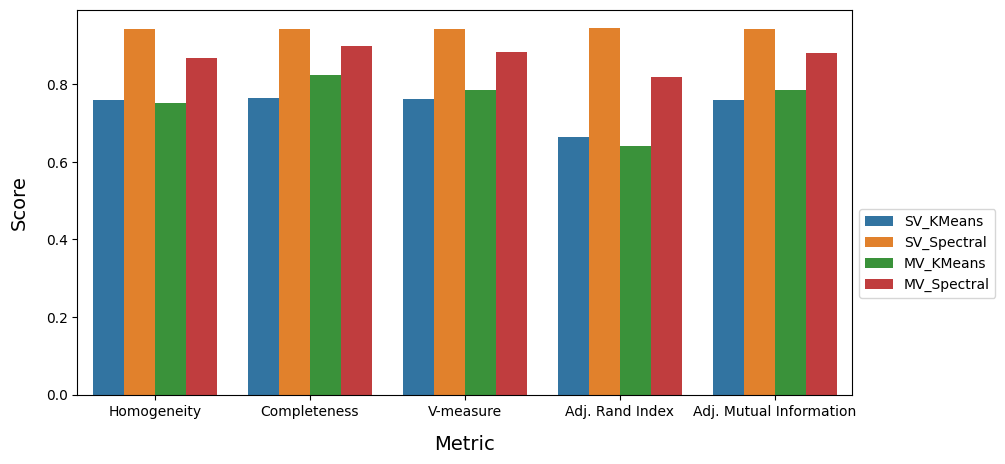

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='metric', y='value', hue='variable', data=result_df)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel("Metric", labelpad=12, fontsize=14)
plt.ylabel("Score", labelpad=12, fontsize=14)
plt.show()

In [24]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_tsne_clusters(title, tsne_data, labels, subtitles):
#     plt.figure(figsize=(15, 6))
#     plt.suptitle(title, fontsize=18)
    
#     for i, (label, subtitle) in enumerate(zip(labels, subtitles), 1):
#         plt.subplot(1, 3, i)
#         sns.scatterplot(x = tsne_data.tsne1, y = tsne_data.tsne2,
#                         hue = label, palette='tab10', edgecolor='black', s=100)
#         plt.title(subtitle, fontsize=14)
#         plt.xlabel('tsne1', fontsize=14)
#         plt.ylabel('tsne2', fontsize=14)
#         plt.xticks(fontsize=12)
#         plt.yticks(fontsize=12)
    
#     plt.tight_layout()
#     plt.show()

# tsne_df = ... # Your t-SNE DataFrame
# y_kmeans_sv = ... # Your single view labels for k-means
# y_kmeans_mv = ... # Your multi view labels for k-means
# y_spec_sv = ... # Your single view labels for spectral clustering
# y_spec_mv = ... # Your multi view labels for spectral clustering
# y = ... # Your true labels

# # For K-Means Clustering
# plot_tsne_clusters('K-Means', tsne_df, [y_kmeans_sv, y_kmeans_mv, y], ['Single View', 'Two Views', 'True Labels'])

# # For Spectral Clustering
# plot_tsne_clusters('Spectral Clustering', tsne_df, [y_spec_sv, y_spec_mv, y], ['Single View', 'Two Views', 'True Labels'])
